<a href="https://colab.research.google.com/github/JuanM-GG/maestria/blob/main/ml-lote/Direct_Solver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DirectSolver

In [35]:
pip install pyDOE

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [36]:
pip install torchdyn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [37]:
from argparse import ArgumentParser
from numpy import double
import torch.nn as nn
from torch.optim import Adam
from tqdm import tqdm
from pyDOE import lhs
import matplotlib.pyplot as plt
from torch.nn.functional import mse_loss
import numpy as np

import torch
from torchdyn.numerics import odeint
# from torchdyn.numerics.solvers import SolverTemplate

In [38]:
#@title solver 
class SolverTemplate(nn.Module):
    def __init__(self, order, min_factor: float = 0.2, max_factor: float = 10, safety: float = 0.9):
        super().__init__()
        self.order = order
        self.min_factor = torch.tensor([min_factor])
        self.max_factor = torch.tensor([max_factor])
        self.safety = torch.tensor([safety])
        self.tableau = None

    def sync_device_dtype(self, x, t_span):
        "Ensures `x`, `t_span`, `tableau` and other solver tensors are on the same device with compatible dtypes"

        if isinstance(x, dict):
            proto_arr = x[list(x.keys())[0]]
        elif isinstance(x, torch.Tensor):
            proto_arr = x
        else:
            raise NotImplementedError(
                f"{type(x)} is not supported as the state variable")

        device = proto_arr.device

        if self.tableau is not None:
            c, a, bsol, berr = self.tableau
            self.tableau = c.to(proto_arr), [a.to(proto_arr) for a in a], bsol.to(
                proto_arr), berr.to(proto_arr)
        t_span = t_span.to(device)
        self.safety = self.safety.to(device)
        self.min_factor = self.min_factor.to(device)
        self.max_factor = self.max_factor.to(device)
        return x, t_span

    def step(self, f, x, t, dt, k1=None, args=None):
        pass


class DirectSolver(SolverTemplate):
    def __init__(self, dtype=torch.float32):
        super().__init__(order=1)
        self.dtype = dtype
        self.stepping_class = "fixed"

    def step(self, f, x, t, dt, k1=None, args=None):

        x_sol = f(t, x)
        return None, x_sol, None


In [39]:
# modelo de biorreactor
def f(t, x):
    b = x[..., 0]
    s = x[..., 1]
    p = x[..., 2]

    # parámetros cinéticos
    mu = 1.2 # 1/h
    ks = 280 # g/L
    Yxs = 0.2 
    Ypx = 4 
    ki = 0.3

    # balances de masa
    db = mu*(s / (ks + s + ki*s**2))*b 
    ds = -1/Yxs*mu*(s / (ks + s + ki*s**2))*b 
    dp = Ypx*mu*(s / (ks + s + ki*s**2))*b

    return torch.stack((db, ds, dp), dim=-1)

In [40]:
db = torch.tensor([1])
ds = torch.tensor([3])
dp = torch.tensor([5])
torch.stack((db, ds, dp), dim=-1)

tensor([[1, 3, 5]])

In [41]:
# condiciones iniciales para el entrenamiento
num_trayectorias_entrenamiento = 100
# datos 'reales' para el entrenamiento
x0_train = (
    torch.tensor(lhs(3, num_trayectorias_entrenamiento), device='cpu') 
) 
x0_train[:,0] = x0_train[:,0] * 10 + 0.2 # biomasa (0.2-10.2)
x0_train[:,1] = x0_train[:,1]* 40 # sustrato (0-40)
x0_train[:,2] = x0_train[:,2]* 40 # producto (0-40)
print(x0_train[0:5,:]) 
print(x0_train.shape)

tensor([[ 8.6543, 28.3682, 31.1465],
        [ 1.6945, 26.6229,  9.7777],
        [ 5.1207, 21.5807, 11.3439],
        [ 8.1265, 19.3370, 10.6275],
        [ 4.7283, 12.9278, 36.4048]], dtype=torch.float64)
torch.Size([100, 3])


In [42]:
# It is irrelevant to write lhs(3, 10) or lhs(10, 3) 
torch.tensor(lhs(3, 10)) 

tensor([[0.7842, 0.0950, 0.5561],
        [0.1675, 0.6200, 0.6950],
        [0.6155, 0.3192, 0.2053],
        [0.5160, 0.1104, 0.7571],
        [0.9145, 0.9461, 0.4783],
        [0.3682, 0.8579, 0.8765],
        [0.8478, 0.2419, 0.0606],
        [0.2634, 0.4293, 0.1618],
        [0.0588, 0.7866, 0.9058],
        [0.4642, 0.5049, 0.3139]], dtype=torch.float64)

In [43]:
# condiciones iniciales para la validación de la red
num_trayectorias_validacion = 10
x0_validate = (
    torch.tensor(lhs(3, num_trayectorias_validacion), device='cpu') 
)
x0_validate[:,0] = x0_validate[:,0] + 0.2 # biomasa (0.2-1.2)
x0_validate[:,1] = x0_validate[:,1]* 20 + 20 # sustrato (20-40)
x0_validate[:,2] = x0_validate[:,2]* 0 # producto (0)
print(x0_validate[0:5,:]) 
print(x0_validate.shape)

tensor([[ 0.4608, 23.8805,  0.0000],
        [ 0.2017, 26.1530,  0.0000],
        [ 0.6531, 20.2212,  0.0000],
        [ 0.8685, 34.0118,  0.0000],
        [ 0.5695, 28.1104,  0.0000]], dtype=torch.float64)
torch.Size([10, 3])


In [44]:
# tiempo de entrenamiento, son trayectorias cortas de una hora 
# (tomar muestras cada hora es algo razonable)
step_size_train = 1
ε = 1e-10 # solo para asegurar que se incluye el tiempo final
t_span_train = torch.arange(
    0.0, 
    1 + ε,
    step_size_train
)

# tiempo para la validación, esto se va a comparar con la simulación del modelo mecanistico
t_span_validate = torch.arange(
    0.0,
    60 + ε,
    step_size_train
)

In [45]:
t_span_train # trayectoría de 1 hora para el entrenamiento

tensor([0., 1.])

In [46]:
t_span_validate # trayectorías de 60 horas para la validación

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27.,
        28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39., 40., 41.,
        42., 43., 44., 45., 46., 47., 48., 49., 50., 51., 52., 53., 54., 55.,
        56., 57., 58., 59., 60.])

In [47]:
solver = DirectSolver()

In [48]:
print(solver)

DirectSolver()


In [49]:
# obtenemos x(1) para cada una de las 100 condiciones iniciales, x(0), de entrenamiento
# esta simulación representa nuestros datos 'reales' para el entrenamiento de la red
_, x_train = odeint(f, x0_train, t_span_train, solver="rk4")
# returns (t_eval, solution )
x_true = x_train

In [50]:
print(_)
print()
print(x_true[:, :5, :])

tensor([0., 1.])

tensor([[[ 8.6543, 28.3682, 31.1465],
         [ 1.6945, 26.6229,  9.7777],
         [ 5.1207, 21.5807, 11.3439],
         [ 8.1265, 19.3370, 10.6275],
         [ 4.7283, 12.9278, 36.4048]],

        [[ 9.2042, 25.6186, 33.3462],
         [ 1.8019, 26.0860, 10.2072],
         [ 5.4263, 20.0525, 12.5665],
         [ 8.5850, 17.0446, 12.4614],
         [ 4.9407, 11.8659, 37.2543]]], dtype=torch.float64)


In [51]:
# el orden de las dimensiones es:
# 2 observaciones en tiempo (la inicial, x(0) y la que se obtiene mediante integración numérica, x(1))
# 100 trayectorias, cada una con dos observaciones
# 3 variables de estado, en este caso: biomasa, sustrato y producto
print(x_train.shape)
print(x0_train.shape)

torch.Size([2, 100, 3])
torch.Size([100, 3])


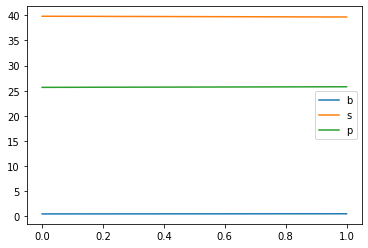

In [52]:
# en la trayectoría número 10 así cambia la biomasa, el sustrato y el producto en un intervalo de 1 hora
trayectoria = 10
plt.plot(x_true[:, trayectoria, 0], label='b')
plt.plot(x_true[:, trayectoria, 1], label='s')
plt.plot(x_true[:, trayectoria, 2], label='p')
plt.legend()

In [53]:
# obtenemos las trayectorias x(t) para las condiciones iniciales de los 
# datos de validación, esto también se considera 'real'
_, x_validate = odeint(f, x0_validate, t_span_validate, solver="rk4")
# obtenemos la trayectoría x(t) para el estado inicial del ejemplo
# esto también se considera 'real'
# _, x_example = odeint(f, x0_example, t_span_validate, solver="rk4")

In [54]:
print(x0_validate.shape) # le damos 10 condiciones iniciales para que simule una trayectoria de 24 horas
print(x_validate.shape) # observaciones en el tiempo, trayectoría, variables de estado
# print(x0_example.shape) # solo una condición inicial para que simule una trayectoria de 24 horas
# print(x_example.shape)

torch.Size([10, 3])
torch.Size([61, 10, 3])


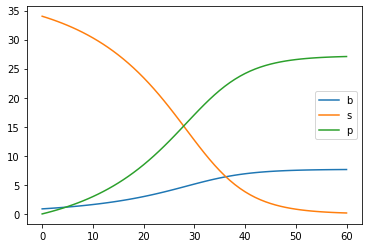

In [55]:
# trayectoría de validación 'real' número 3
trayectoria = 3
plt.plot(x_validate[:, trayectoria, 0], label = 'b')
plt.plot(x_validate[:, trayectoria, 1], label = 's')
plt.plot(x_validate[:, trayectoria, 2], label = 'p')
plt.legend()

In [56]:
##################### red neuronal ##########################
layers = []
layers.append(nn.Linear(3, 32)) # capa de entrada
for _ in range(8):
    layers.append(nn.Linear(32, 32)) # capas escondidas
    layers.append(nn.Softplus()) # función de activación para cada capa escondida

layers.append(nn.Linear(32, 3)) # capa de salida

net = nn.Sequential(*layers) # crear red
net.to('cpu').double()

# inicializar pesos de la red
for m in net.modules():
    if type(m) == nn.Linear:
        # Initialize the weights of the Linear module using xavier_uniform_
        nn.init.xavier_uniform_(m.weight)

In [57]:
# optimizer
opt = Adam(net.parameters()) # creo que Adam usa una función de activación en la 
# capa de salida y por eso nosotros ya no usamos nada en la red de forma explícita

In [58]:
# entrenamiento de la red
losses = []

for _ in tqdm(range(2000)): # epochs es 2000

    # para hacer esto con un input vas a tener que hacerlo a mano usando un ciclo for

    # 1. Forward pass
    _, x_pred_train = odeint(
        lambda t, x: net(x), # le tengo que pasar el tiempo a fuerzas
        # al final t no hace nada pero la funcion f lo debe recibir
        x0_train, # (100, 3) usamos 100 condiciones iniciales para generar 100 trayectorías de una hora 
        t_span_train, # 1 hora, tensor([0., 1.])
        solver=solver
    )

    # 2. Calculate loss
    loss = mse_loss(x_pred_train, x_train) # calcula función loss (error)

    # 3. Zero grad
    opt.zero_grad() # después de cada iteración hay que hacer el gradiente 0 para que 
    # no se acumule
    
    # 4. Backward pass
    loss.backward() # calcular las derivadas 

    # 5. Update weights and biases
    opt.step() # iterar para cambiar los pesos de acuerdo a las derivadas

    losses.append(loss.item()) # guardar el valor de la función loss

100%|██████████| 2000/2000 [00:09<00:00, 218.72it/s]


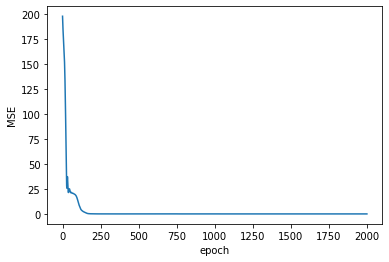

In [59]:
# show
fig, ax = plt.subplots()
ax.plot(losses)
ax.set_xlabel("epoch")
ax.set_ylabel("MSE")

plt.show()

In [60]:
print(x0_train.shape) # input del entrenamiento
print(x_train.shape) # output 'real'
print(x_pred_train.shape) # output predicha con la red en el entrenamiento en la iteración
# 20000

torch.Size([100, 3])
torch.Size([2, 100, 3])
torch.Size([2, 100, 3])


In [61]:
print(x_train[0, 0, :]) # output 'real'
print(x_pred_train[0, 0, :]) # output predicha con la red en el entrenamiento en la iteración

tensor([ 8.6543, 28.3682, 31.1465], dtype=torch.float64)
tensor([ 8.6543, 28.3682, 31.1465], dtype=torch.float64,
       grad_fn=<SliceBackward0>)


In [62]:
# VAMOS A COMPROBAR QUE LA RED FUNCIONÓ
_, x_pred_validate = odeint(lambda t, x: net(
    x), x0_validate, t_span_validate, solver=solver
) # predicción con la red ya entrenada, pero usando nuevos datos que la red no ha visto
# varias condiciones iniciales

In [63]:
print(x_pred_validate.shape) # num de observaciones en el tiempo, trayectorias, variables de estado
# print(x_pred_example.shape)

torch.Size([61, 10, 3])


In [64]:
# para graficar hay que convertir a arreglos de numpy
x_pred_validate = x_pred_validate.detach().numpy()
# x_pred_example = x_pred_example.detach().numpy()

In [65]:
x_pred_validate[:10,3,:] # una de las trayectorías predichas con la red
# usando las condiciones iniciales de validación
# se ve bien :D

array([[ 0.86847445, 34.01178554,  0.        ],
       [ 1.43873385, 32.4965917 ,  1.84478993],
       [ 1.78059686, 31.74700594,  2.66550703],
       [ 2.0188952 , 31.12087014,  3.24922207],
       [ 2.20351496, 30.50079375,  3.76158445],
       [ 2.35881404, 29.8527565 ,  4.26217263],
       [ 2.49922803, 29.16283314,  4.78072512],
       [ 2.63433574, 28.42394294,  5.33554716],
       [ 2.7705822 , 27.63295546,  5.93910723],
       [ 2.91181446, 26.79084701,  6.59948227]])

In [66]:
print(x_validate.shape) # real
print(x_pred_validate.shape) # predicho

torch.Size([61, 10, 3])
(61, 10, 3)


In [67]:
x_validate[..., 0, 1] == x_validate[:, 0, 1] # es lo mismo ;D

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True])

Validación 1


<ipython-input-69-444fdf35470b>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(131)
<ipython-input-69-444fdf35470b>:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(132)
<ipython-input-69-444fdf35470b>:51: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and return

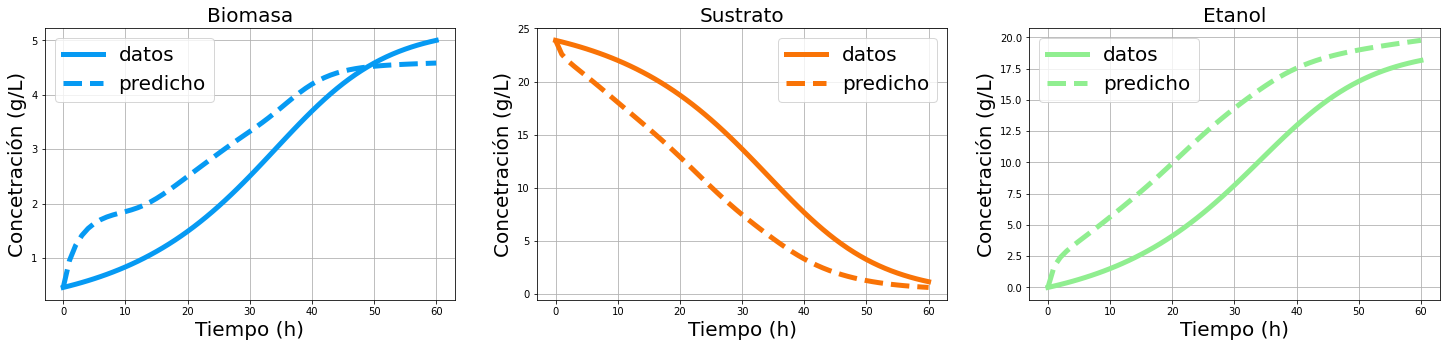

In [69]:
# for i in range(x_validate.shape[1]):
i = 0
print("Validación", i+1)
plt.figure(figsize = (25,5))

# la biomasa (0)
plt.subplot(131)
plt.plot(t_span_validate, 
    x_validate[..., i, 0], # lo real
    color="#069AF3", label = 'datos', linewidth = 5)

# el sustrato (1)
plt.subplot(132)
plt.plot(
    t_span_validate, 
    x_validate[..., i, 1], # lo real
    color="#F97306", label = 'datos', linewidth = 5)
# el producto (2)
plt.subplot(133)
plt.plot(t_span_validate, 
        x_validate[..., 0, 2], # lo real
        color="lightgreen", label = 'datos', linewidth = 5)

##### datos predichos ######
plt.subplot(131)
plt.plot(
    t_span_validate,
    x_pred_validate[..., i, 0], label = 'predicho', # lo predicho
    linestyle="dashed",
    color="#069AF3", linewidth = 5)
plt.grid()
plt.xlabel("Tiempo (h)", size = 20)
plt.ylabel("Concetración (g/L)", size = 20)
plt.title("Biomasa", size = 20)
plt.legend(fontsize = 20)


plt.subplot(132)
plt.plot(
    t_span_validate,
    x_pred_validate[..., i, 1], label = 'predicho', # lo predicho
    linestyle="dashed",
    color='#F97306', linewidth = 5)
plt.grid()
plt.xlabel("Tiempo (h)", size = 20)
plt.ylabel("Concetración (g/L)", size = 20)
plt.title("Sustrato", size = 20)
plt.legend(fontsize = 20)


plt.subplot(133)
plt.plot(
    t_span_validate,
    x_pred_validate[..., i, 2], label = 'predicho', # lo predicho
    linestyle="dashed",
    color="lightgreen", linewidth = 5)

plt.grid()
plt.xlabel("Tiempo (h)", size = 20)
plt.ylabel("Concetración (g/L)", size = 20)
plt.title("Etanol", size = 20)
plt.legend(fontsize = 20)
plt.show()

    